In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interpolate
from craftroom import resample
import stistools
#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


/home/david/anaconda3/lib/python3.7/site-packages/stsci/tools/nmpfit.py:10: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/home/david/anaconda3/lib/python3.7/site-packages/stsci/tools/gfit.py:20: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


making a quick fake dq 

In [2]:
data = Table.read('extracted_spectra/TRAPPIST-1_G140M_all_coadd2.ecsv')

In [3]:
dq = np.zeros(len(data['WAVELENGTH']))

In [4]:
data['DQ'] = dq

In [5]:
data

WAVELENGTH,FLUX,ERROR,DQ
Angstrom,erg / (Angstrom cm2 s),erg / (Angstrom cm2 s),
float64,float64,float64,float64
1194.37721698802,-1.833916440485774e-16,2.5202795376958417e-20,0.0
1194.4305041995433,-1.7901713199101087e-16,2.5359262925815004e-20,0.0
1194.483791118679,-1.7721208561486587e-16,2.6404886579197337e-20,0.0
1194.5370777454316,-1.7327664184066406e-16,2.759147715170851e-20,0.0
1194.5903640798065,-1.4778437633074495e-16,2.6498475354568386e-20,0.0
1194.6436501218082,-1.5632977462487717e-16,2.755954299424868e-20,0.0
1194.6969358714418,-9.990377533124539e-17,3.102219228454872e-20,0.0
1194.7502213287116,-4.419407923641826e-17,3.275252262088243e-20,0.0


In [6]:
ascii.write(data, 'extracted_spectra/TRAPPIST-1_G140M_fake_dq.ecsv', format='ecsv', overwrite=True)

Can I coadd it better?

In [7]:
def new_coadd(f_array, e_array):
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum(((flux - f_array)**2) * weights, axis=0) / (len(f_array)-1)
    error = (var * rcs)**0.5
    return flux, var, error

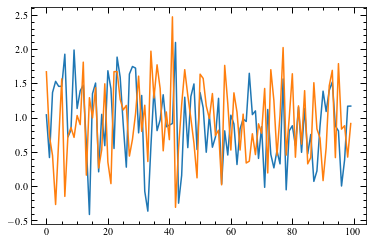

In [8]:
w = np.arange(100)
f1 = np.random.normal(1, 0.5,100)
e1 = np.random.normal(0, 0.5, 100)
f2 = np.random.normal(1, 0.5,100)
e2 = np.random.normal(0, 0.5, 100)
plt.plot(w, f1, w, f2)
#plt.plot(w, e1, w, e2)


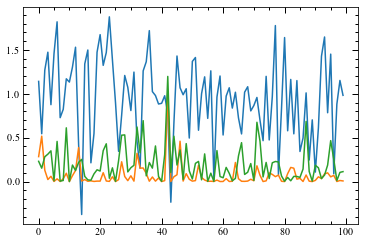

In [9]:
f_av, var, e_av = new_coadd(np.array([f1, f2]), np.array([e1, e2]))
plt.plot(w, f_av)
plt.plot(w, var)
plt.plot(w, e_av)

In [10]:
path = '/home/david/work/muscles/trappist-1/hst/g140m_cals/'
outpath = path + 'picked_trace_extracts/'
new_x1ds = glob.glob(outpath+'*new_x1d.fits')     
picks = Table.read('new_trace_centers.ecsv')

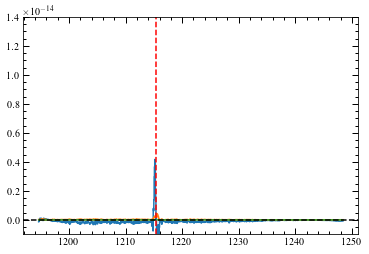

In [11]:
f_new = []
e_new = []
i = 0
for x in new_x1ds:
    rootname = fits.getheader(x,0)['ROOTNAME']
    if picks['A2CENTER'][np.argwhere(picks['ROOTNAME']==rootname)[0][0]] != 0.0:
        data = fits.getdata(x, 1)[0]
        if i == 0:
            w_new = data['WAVELENGTH']
            w_new = np.arange(w_new[5], w_new[-6], np.mean(np.diff(w_new)))
            #f_new.append(data['FLUX'])
            #e_new.append(data['ERROR'])
            #print(len(w_new))
        #else:
        fi = interpolate.interp1d(data['WAVELENGTH'], data['FLUX'], fill_value='extrapolate')(w_new)
        #wi, fi, ei = resample.bintogrid(data['WAVELENGTH'], data['FLUX'], unc=data['ERROR'], newx = w_new)
        f_new.append(fi)
        ei = interpolate.interp1d(data['WAVELENGTH'], data['ERROR'], fill_value='extrapolate')(w_new)
        e_new.append(ei)
        #print(len(wi))
        #plt.step(data['WAVELENGTH'], data['FLUX'])
        #f_new.append(data['FLUX'])
        i += 1

f_new, v_new, e_new = new_coadd(np.array(f_new), np.array(e_new))


plt.step(w_new, f_new)
plt.step(w_new,e_new)
plt.step(w_new, v_new)
#plt.step(w_full, f_full)
#plt.errorbar(w_new, f_new, yerr=e_new)
#plt.plot(lw, lf)
#plt.xlim(1212, 1218)

plt.ylim(-1e-15, 1.4e-14)
plt.axhline(0, c='k', ls ='--')
plt.axvline(1215.44, ls ='--', c='r')

20190715 just the Borrier+17a ones

In [12]:
b_roots = ['od3v01010', 'od3v01020', 'od3v02010','od3v03010']
b_x1ds = []
for x in new_x1ds:
    for b in b_roots:
        if b in x:
            b_x1ds.append(x)
b_x1ds = sorted(b_x1ds)
b_x1ds

['/home/david/work/muscles/trappist-1/hst/g140m_cals/picked_trace_extracts/od3v01010_new_x1d.fits',
 '/home/david/work/muscles/trappist-1/hst/g140m_cals/picked_trace_extracts/od3v01020_new_x1d.fits',
 '/home/david/work/muscles/trappist-1/hst/g140m_cals/picked_trace_extracts/od3v02010_new_x1d.fits',
 '/home/david/work/muscles/trappist-1/hst/g140m_cals/picked_trace_extracts/od3v03010_new_x1d.fits']

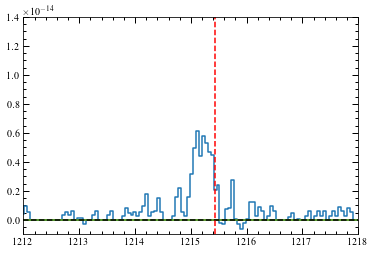

In [13]:
f_new = []
e_new = []
i = 0
for x in b_x1ds:
    rootname = fits.getheader(x,0)['ROOTNAME']
    #if picks['A2CENTER'][np.argwhere(picks['ROOTNAME']==rootname)[0][0]] != 0.0:
     #   data = fits.getdata(x, 1)[0]
    if i == 0:
        w_new = data['WAVELENGTH']
        w_new = np.arange(w_new[5], w_new[-6], np.mean(np.diff(w_new)))
        #f_new.append(data['FLUX'])
        #e_new.append(data['ERROR'])
        #print(len(w_new))
    #else:
    fi = interpolate.interp1d(data['WAVELENGTH'], data['FLUX'], fill_value='extrapolate')(w_new)
    #wi, fi, ei = resample.bintogrid(data['WAVELENGTH'], data['FLUX'], unc=data['ERROR'], newx = w_new)
    f_new.append(fi)
    ei = interpolate.interp1d(data['WAVELENGTH'], data['ERROR'], fill_value='extrapolate')(w_new)
    e_new.append(ei)
    #print(len(wi))
    #plt.step(data['WAVELENGTH'], data['FLUX'])
    #f_new.append(data['FLUX'])
    i += 1

f_new, v_new, e_new = new_coadd(np.array(f_new), np.array(e_new))


plt.step(w_new, f_new, where='mid')
plt.step(w_new,e_new, where='mid')
plt.step(w_new, v_new, where='mid')
#plt.step(w_full, f_full)
#plt.errorbar(w_new, f_new, yerr=e_new)
#plt.plot(lw, lf)
plt.xlim(1212, 1218)

plt.ylim(-1e-15, 1.4e-14)
plt.axhline(0, c='k', ls ='--')
plt.axvline(1215.44, ls ='--', c='r')

od3v01010 2016-09-26


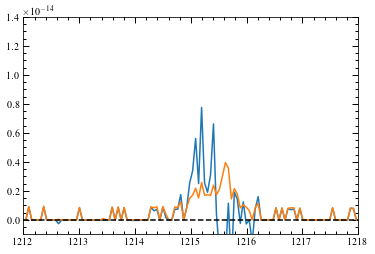

od3v01020 2016-09-26


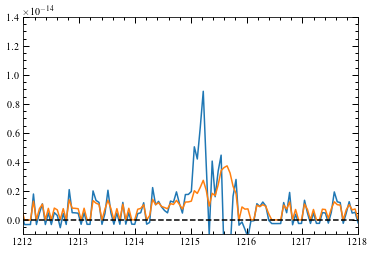

od3v02010 2016-09-30


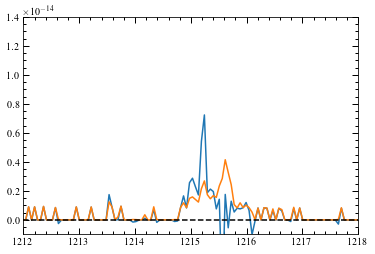

od3v03010 2016-11-23


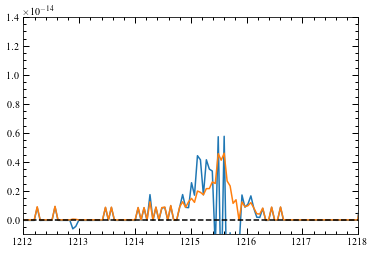

In [14]:
for x in b_x1ds:
    data = fits.getdata(x,1)[0]
    rootname = fits.getheader(x, 0)['ROOTNAME'] 
    date = fits.getheader(x, 0)['TDATEOBS']
    
   # if date in dates[0:3]:
    print(rootname,date)
    #plt.step(data['WAVELENGTH'], data['FLUX'], where='mid')
    #plt.step(data['WAVELENGTH'], data['ERROR'], where='mid')
    plt.plot(data['WAVELENGTH'], data['FLUX'])
    plt.plot(data['WAVELENGTH'], data['ERROR'])
    
   # plt.plot(lw, lf)
    plt.xlim(1212, 1218)

    plt.ylim(-1e-15, 1.4e-14)
    plt.axhline(0, c='k', ls ='--')
    #plt.axvline(1215.44, ls ='--', c='r')
    plt.show()

od3v01010
od3v01020


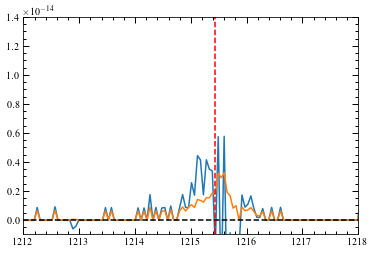

In [15]:
f_1st = []
e_1st = []
i = 0
for x in b_x1ds[0:2]:
    rootname = fits.getheader(x,0)['ROOTNAME']
    print(rootname)
    #if picks['A2CENTER'][np.argwhere(picks['ROOTNAME']==rootname)[0][0]] != 0.0:
     #   data = fits.getdata(x, 1)[0]
    if i == 0:
        w_1st = data['WAVELENGTH']
        #w_new = np.arange(w_new[5], w_new[-6], np.mean(np.diff(w_new)))
        #f_new.append(data['FLUX'])
        #e_new.append(data['ERROR'])
        #print(len(w_new))
    #else:
    fi = interpolate.interp1d(data['WAVELENGTH'], data['FLUX'], fill_value='extrapolate')(w_1st)
    #wi, fi, ei = resample.bintogrid(data['WAVELENGTH'], data['FLUX'], unc=data['ERROR'], newx = w_new)
    f_1st.append(fi)
    ei = interpolate.interp1d(data['WAVELENGTH'], data['ERROR'], fill_value='extrapolate')(w_1st)
    e_1st.append(ei)
    #print(len(wi))
    #plt.step(data['WAVELENGTH'], data['FLUX'])
    #f_new.append(data['FLUX'])
    i += 1

#f_1st, v_1st, e_1st = new_coadd(np.array(f_1st), np.array(e_1st))
f_1st, e_1st = np.mean(f_1st, axis=0), np.mean(e_1st, axis=0)/2**0.5


#plt.step(w_1st, f_1st, where='mid')
#plt.step(w_1st,e_1st, where='mid')
#plt.step(w_1st, v_1st, where='mid')
plt.plot(w_1st, f_1st)
plt.plot(w_1st, e_1st)
#plt.step(w_full, f_full)
#plt.errorbar(w_new, f_new, yerr=e_new)
#plt.plot(lw, lf)
plt.xlim(1212, 1218)

plt.ylim(-1e-15, 1.4e-14)
plt.axhline(0, c='k', ls ='--')
plt.axvline(1215.44, ls ='--', c='r')

od3v02010
od3v03010


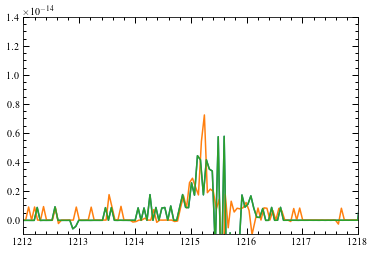

In [16]:
plt.plot(w_1st, f_1st)

for x in [b_x1ds[2],b_x1ds[3]]:
    rootname = fits.getheader(x,0)['ROOTNAME']
    print(rootname)
    
    data = fits.getdata(x,1)[0]
    plt.plot(data['WAVELENGTH'], data['FLUX'])
   # plt.plot(data['WAVELENGTH'], data['ERROR'])
    plt.xlim(1212, 1218)

    plt.ylim(-1e-15, 1.4e-14)
  #  plt.axhline(0, c='k', ls ='--')
    #plt.axvline(1215.44, ls ='--', c='r')
   # plt.show()


Re-extract with their values:

In [17]:
b_centers = np.array([415, 415, 416, 176])
my_ys = [415, 415, 416,176]
my_xs = [390, 390, 390, 396]

In [18]:
def build_trace_grid(SPTRCTAB, grating, cenwave):
    """
    Extends a grid of trace displacements to cover all y positions
    """
    data = fits.getdata(SPTRCTAB, 1)
    tracedata = data[(data['OPT_ELEM']==grating) & (data['CENWAVE'] == cenwave)]
    all_y = np.arange(len(tracedata[0]['A2DISPL']))
    grid = interpolate.interp1d(tracedata['A2CENTER'], tracedata['A2DISPL'], axis=0, fill_value='extrapolate')(all_y)
    tracegrid = [a+b for a, b in zip(grid, all_y)] 
    return tracegrid
    
def get_a2center(x, y, tracegrid):
    """
    get the trace a2center at a1center
    """
    xcol = np.array(tracegrid)[:,int(x)]
    xind = (np.abs(xcol - y)).argmin()
    a2center = xind + 1 #calstis is 1-indexed 
    return a2center


In [19]:
b_flts = ['/home/david/work/muscles/trappist-1/hst/g140m_cals/all_obs/od3v01010_flt.fits',
 '/home/david/work/muscles/trappist-1/hst/g140m_cals/all_obs/od3v01020_flt.fits',
 '/home/david/work/muscles/trappist-1/hst/g140m_cals/all_obs/od3v02010_flt.fits',
 '/home/david/work/muscles/trappist-1/hst/g140m_cals/all_obs/od3v03010_flt.fits']
rawpath = '/home/david/work/muscles/trappist-1/hst/g140m_cals/all_obs/'
outpath = '/home/david/work/muscles/trappist-1/hst/g140m_cals/b_extract/' 
os.environ['oref'] = '/home/david/work/muscles/trappist-1/hst/g140m_cals/all_obs/'

In [21]:
b_x1ds = glob.glob(outpath+'*new_x1d.fits')
if len(b_x1ds) > 0:
    [os.remove(x) for x in b_x1ds]

i = 0
for flt in b_flts:
    if i == 0:
        SPTRCTAB = fits.getheader(flt,0)['SPTRCTAB']
        grating = fits.getheader(flt,0)['OPT_ELEM']
        cenwave = fits.getheader(flt,0)['CENWAVE']
        tracegrid = build_trace_grid(rawpath+SPTRCTAB[5:], grating, cenwave)
       # i +=1
    rootname = fits.getheader(flt,0)['ROOTNAME']
    #print(rootname)
    #y = centers[np.argwhere(picks['ROOTNAME']==rootname)[0][0]]
    #x = xpicks[np.argwhere(picks['ROOTNAME']==rootname)[0][0]]
    y = my_ys[i]
    x = my_xs[i]
    a2center = get_a2center(x,y, tracegrid)
    stistools.x1d.x1d(flt, output=outpath+rootname+'_new_x1d.fits', verbose=True, trailer='trl_files/b_recal.trl',a2center=a2center, 
                      maxsrch=10)#, bk1size=14, bk2size=14, bk1offst=-13, bk2offst=13)
    i += 1

b_x1ds = glob.glob(outpath+'*new_x1d.fits')                
print(len(b_x1ds))

for x in b_x1ds:
    
    data = fits.getdata(x,1)[0]
    plt.plot(data['WAVELENGTH'], data['FLUX'])
   # plt.plot(data['WAVELENGTH'], data['ERROR'])
    plt.xlim(1212, 1218)

    plt.ylim(-1e-15, 1.4e-14)

Appending to trailer file trl_files/b_recal.trl
Running x1d on /home/david/work/muscles/trappist-1/hst/g140m_cals/all_obs/od3v01010_flt.fits
  ['cs6.e', '/home/david/work/muscles/trappist-1/hst/g140m_cals/all_obs/od3v01010_flt.fits', '/home/david/work/muscles/trappist-1/hst/g140m_cals/b_extract/od3v01010_new_x1d.fits', '-v', '-back', '-cte', '-disp', '-hel', '-flux', '-c', '418', '-r', '10', '-bm', '-bo', '3', '-a', 'unweighted']


FileNotFoundError: [Errno 2] No such file or directory: 'cs6.e': 'cs6.e'

In [ ]:
f_new = []
e_new = []
i = 0
for x in b_x1ds[0:2]:
    rootname = fits.getheader(x,0)['ROOTNAME']
    if picks['A2CENTER'][np.argwhere(picks['ROOTNAME']==rootname)[0][0]] != 0.0:
        data = fits.getdata(x, 1)[0]
        if i == 0:
            w_new = data['WAVELENGTH']
            w_new = np.arange(w_new[5], w_new[-6], np.mean(np.diff(w_new)))
            #f_new.append(data['FLUX'])
            #e_new.append(data['ERROR'])
            #print(len(w_new))
        #else:
        fi = interpolate.interp1d(data['WAVELENGTH'], data['FLUX'], fill_value='extrapolate')(w_new)
        #wi, fi, ei = resample.bintogrid(data['WAVELENGTH'], data['FLUX'], unc=data['ERROR'], newx = w_new)
        f_new.append(fi)
        ei = interpolate.interp1d(data['WAVELENGTH'], data['ERROR'], fill_value='extrapolate')(w_new)
        e_new.append(ei)
        #print(len(wi))
        #plt.step(data['WAVELENGTH'], data['FLUX'])
        #f_new.append(data['FLUX'])
        i += 1

#f_new, v_new, e_new = new_coadd(np.array(f_new), np.array(e_new))
f_new, e_new = np.mean(f_new, axis=0), np.mean(e_new, axis=0)/2**0.5

lya = 1215.44*u.AA
dv = (w_new*u.AA).to(u.km/u.s, equivalencies=u.doppler_optical(lya))
#plt.step(w_new, f_new, where='mid')
#plt.step(w_new,e_new, where='mid')
plt.step(dv, f_new, where='mid')
plt.step(dv,e_new, where='mid')
#plt.step(w_new, v_new, where='mid')
#plt.step(w_full, f_full)
#plt.errorbar(w_new, f_new, yerr=e_new)
#plt.plot(lw, lf)
#plt.xlim(1212, 1218)
plt.xlim(-300,300)
plt.ylim(-1e-15, 0.9e-14)
plt.axhline(0, c='k', ls ='--')
#plt.axvline(1215.44, ls ='--', c='r')
plt.axvline(0, ls ='--', c='r')

print(max(f_new))

In [ ]:
savedata = Table([w_new, f_new, e_new], names=['WAVELENGTH','FLUX','ERROR'])
ascii.write(savedata, 'b17_g140m_out_of_transit.ecsv', format='ecsv')

In [ ]:
our_mean = Table.read('extracted_spectra/TRAPPIST-1_G140M_all_coadd2.ecsv')

In [ ]:
plt.plot(our_mean['WAVELENGTH'], our_mean['FLUX'])
plt.plot(w_new, f_new)
plt.xlim(1212, 1218)
